In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
%matplotlib inline

In [7]:
import pandas as pd
import numpy as np
import os

In [8]:
path = '../data/features_180228.csv'
df = pd.read_csv(path)
df.rename(columns=lambda x: x.replace(',','').replace(' ',''),inplace=True)
df.head(5)

,zip,price,sqft,bedrooms,sale_type,ZIPCODE,total_parks,total_park_area,total_lines,total_stations,...,TotalPop,2000,2010,2010TotalAcres,total_bus,CigaretteRetailDealer,Newsstand,Laundries,Laundry,SidewalkCafe
0,10001,2488000.0,1536.0,2.0,Condo For Sale,10001.0,33.0,365798.032282,22.0,7.0,...,135500.0,110137.0,117792.0,2664.76,498.0,93.0,23.0,14.0,2.0,9.0
1,10001,5750000.0,2146.0,3.0,Condo For Sale,10001.0,33.0,365798.032282,22.0,7.0,...,135500.0,110137.0,117792.0,2664.76,498.0,93.0,23.0,14.0,2.0,9.0
2,10001,2850000.0,2700.0,3.0,Condo For Sale,10001.0,33.0,365798.032282,22.0,7.0,...,135500.0,110137.0,117792.0,2664.76,498.0,93.0,23.0,14.0,2.0,9.0
3,10001,13880000.0,3364.0,4.0,Condo For Sale,10001.0,33.0,365798.032282,22.0,7.0,...,135500.0,110137.0,117792.0,2664.76,498.0,93.0,23.0,14.0,2.0,9.0
4,10001,9255000.0,2566.0,3.0,Condo For Sale,10001.0,33.0,365798.032282,22.0,7.0,...,135500.0,110137.0,117792.0,2664.76,498.0,93.0,23.0,14.0,2.0,9.0


In [9]:
from sklearn.preprocessing import LabelEncoder

lbl = LabelEncoder()
lbl.fit(df['sale_type'].values)
df['s_type'] = lbl.transform(df['sale_type'].values)

In [10]:
df = df[df['price'] < df['price'].quantile(.9)]
df.drop(['zip','ZIPCODE'], axis=1, inplace=True)

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_numeric = df.select_dtypes(include=numerics)

In [11]:
df_numeric.shape

(9134, 34)

In [12]:
df_numeric.dropna(inplace=True)
df_numeric.shape

(9134, 34)

In [13]:
df_numeric.columns

Index(['price', 'sqft', 'bedrooms', 'total_parks', 'total_park_area',
       'total_lines', 'total_stations', '$1under$25000', '$100000under$200000',
       '$200000ormore', '$25000under$50000', '$50000under$75000',
       '$75000under$100000', 'total_crimes', 'BURGLARY', 'DANGEROUSWEAPONS',
       'DANGEROUSDRUGS', 'FELONYASSAULT', 'ROBBERY', 'FELONY', 'MISDEMEANOR',
       'VIOLATION', 'total_projects', 'TotalPop', '2000', '2010',
       '2010TotalAcres', 'total_bus', 'CigaretteRetailDealer', 'Newsstand',
       'Laundries', 'Laundry', 'SidewalkCafe', 's_type'],
      dtype='object')

In [14]:
X = df_numeric.drop('price',axis=1)
target = df_numeric['price']

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
predictors = scaler.fit_transform(X)
scaled_data = pd.DataFrame(predictors, columns=X.columns)

In [16]:
from sklearn.cross_validation import train_test_split

pred_train, pred_test, tar_train, tar_test = train_test_split(X, 
                            target, test_size=.3, random_state=123)

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [17]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression()
lin_model.fit(pred_train, tar_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [18]:
score = lin_model.score(pred_test, tar_test)
print('model score: %s' % score)

model score: 0.453612632509


In [14]:
# temp_X = df_numeric[['sqft','Sidewalk Cafe','total_stations',
#                      '$100,000 under $200,000','$200,000 or more',
#                     'bedrooms','total_lines','Newsstand','Laundries']]

In [15]:
# pred_train, pred_test, tar_train, tar_test = train_test_split(temp_X, 
#                             target, test_size=.3, random_state=123)

# lin_model = LinearRegression()
# lin_model.fit(pred_train, tar_train)

In [16]:
# score = lin_model.score(pred_test, tar_test)
# print('model score: %s' % score)

In [19]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

features_to_use = list(X.columns)
d = []

In [20]:
n_features_remove = 1
min_features = 4

In [21]:
model_scores = []
n_feats = []

In [22]:
while len(features_to_use)>=min_features:
    pred_trainRF = pred_train[features_to_use]
    pred_testRF = pred_test[features_to_use]
    
    # Build regressor
    rgr = DecisionTreeRegressor(random_state=0,max_depth=None)
    rgr.fit(pred_trainRF, tar_train)
    
    # Model scores
    r_score = rgr.score(pred_testRF, tar_test)
    d.append({'score': r_score, 'n_features': len(features_to_use),
             'features_used': ','.join(features_to_use),
             'feature_importances': rgr.feature_importances_})
    
    # sort features by importance
    sorted_idx = np.argsort(rgr.feature_importances_)
    # reverse order
    sorted_idx = sorted_idx[::-1]
    # remove worst performing feature
    sorted_idx = sorted_idx[:-n_features_remove]
    
    # swap features list with the trimmed features
    temp = features_to_use
    features_to_use=[]
    for feat in sorted_idx:
        features_to_use.append(temp[feat])

results_df = pd.DataFrame(d)

In [23]:
results_df.sort_values(by='score',ascending=False,inplace=True)
results_df.head(10)

,feature_importances,features_used,n_features,score
14,"[0.399027010254, 0.297383259829, 0.06122047397...","sqft,$200000ormore,SidewalkCafe,$50000under$75...",19,0.712760
15,"[0.398111149378, 0.29885682388, 0.059676331986...","sqft,$200000ormore,SidewalkCafe,$25000under$50...",18,0.709640
16,"[0.399028745834, 0.299197369744, 0.04096291221...","sqft,$200000ormore,$50000under$75000,SidewalkC...",17,0.705722
17,"[0.398743495791, 0.298941981742, 0.05995943556...","sqft,$200000ormore,SidewalkCafe,$50000under$75...",16,0.704479
18,"[0.400065715561, 0.301222024219, 0.05847592132...","sqft,$200000ormore,SidewalkCafe,$50000under$75...",15,0.704350
0,"[0.397175411699, 0.0362138882143, 0.0042776875...","sqft,bedrooms,total_parks,total_park_area,tota...",33,0.704222
25,"[0.402736679888, 0.315129087376, 0.07312190978...","sqft,$200000ormore,SidewalkCafe,$50000under$75...",8,0.703202
6,"[0.39786650056, 0.298340489691, 0.057020724648...","sqft,$200000ormore,SidewalkCafe,bedrooms,$5000...",27,0.701727
23,"[0.401934271595, 0.303950219172, 0.06843790862...","sqft,$200000ormore,SidewalkCafe,$25000under$50...",10,0.700925
5,"[0.397565025537, 0.297886418286, 0.05675076151...","sqft,$200000ormore,SidewalkCafe,$50000under$75...",28,0.700900


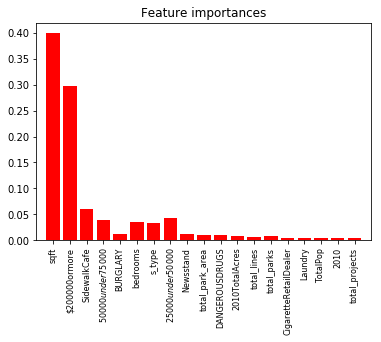

In [24]:
import matplotlib.pylab as plt

feature_names = results_df['features_used'].iloc[0]
feature_names = feature_names.split(',')
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(feature_names)), results_df['feature_importances'].iloc[0],
       color="r", align="center")
plt.xticks(range(len(feature_names)), feature_names)
plt.xticks(rotation=90, size=8)
plt.xlim([-1, len(feature_names)])
plt.show()

In [25]:
best_feature_names = results_df['features_used'].iloc[0]

In [26]:
best_feature_names = best_feature_names.split(',')
print(best_feature_names)

['sqft', '$200000ormore', 'SidewalkCafe', '$50000under$75000', 'BURGLARY', 'bedrooms', 's_type', '$25000under$50000', 'Newsstand', 'total_park_area', 'DANGEROUSDRUGS', '2010TotalAcres', 'total_lines', 'total_parks', 'CigaretteRetailDealer', 'Laundry', 'TotalPop', '2010', 'total_projects']


In [27]:
from sklearn.svm import SVR
from sklearn.grid_search import GridSearchCV

parameters = { 'gamma': np.linspace(.001,1,num=5), 
             'C': np.linspace(.001,1,num=5), 
              'epsilon': np.linspace(.001,1,num=5)}
model = GridSearchCV(SVR(kernel='rbf'), 
                     parameters).fit(pred_train[best_feature_names],
                                    tar_train)

/usr/local/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [29]:
model.score(pred_test[best_feature_names], tar_test)

-0.1462304317262475